# A VVER geometry 
This notebook can be used as a template for modeling VVER reactors.

In [1]:
%matplotlib inline
import openmc

In [2]:
# Materials definitions

au13=openmc.Material(name='au13')
au13.add_element('U', 1.0, enrichment=1.3)
au13.add_element('O', 2.0)
au13.set_density('g/cc', 10.4)

au22=openmc.Material(name='au22')
au22.add_element('U', 1.0, enrichment=2.2)
au22.add_element('O', 2.0)
au22.set_density('g/cc', 10.4)

av5=openmc.Material(name='av5')
av5.add_element('U', 1.0, enrichment=3.0)
av5.add_element('O', 2.0)
av5.set_density('g/cc', 10.4)

awu=openmc.Material(name='awu')
awu.add_element('U', 1.0, enrichment=3.3)
awu.add_element('O', 2.0)
awu.set_density('g/cc', 10.4)

go=openmc.Material(name='go')
go.add_element('U', 1.0, enrichment=4.0)
go.add_element('O', 2.0)
go.set_density('g/cc', 10.4)

Gd2O3=openmc.Material(name='Gd2O3')
Gd2O3.add_element('Gd', 2.0)
Gd2O3.add_element('O', 3.0)
Gd2O3.set_density('g/cm3', 7.41)

water = openmc.Material(name='water')
water.add_nuclide('H1', 2.0)
water.add_nuclide('O16', 1.0)
water.set_density('g/cm3', 1.0)
water.add_s_alpha_beta('c_H_in_H2O')

zirconium = openmc.Material(name="zirconium")
zirconium.add_element('Zr', 1.0)
zirconium.set_density('g/cm3', 6.6)

niobium=openmc.Material(name='niobium')
niobium.add_element('Nb',1.0)
niobium.set_density('g/cm3',8.57)

helium=openmc.Material(name='Helium')
helium.add_element('He', 1.0)
helium.set_density('g/cm3', 0.178e-3)

reflector_mat = openmc.Material(name='Reflector')
reflector_mat.add_nuclide('Be9', 1.0)
reflector_mat.add_nuclide('O16', 1.0)
reflector_mat.set_density('g/cm3', 2.9)

In [3]:
# Material mixtures

alloy = openmc.Material.mix_materials([niobium, zirconium], [0.01, 0.99], 'wo')
fuel_awu = openmc.Material.mix_materials([Gd2O3, awu], [0.05, 0.95], 'wo')
fuel_go = openmc.Material.mix_materials([Gd2O3, go], [0.05, 0.95], 'wo')

In [4]:
# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([au13, au22, av5, fuel_awu, fuel_go, water, alloy, helium, reflector_mat])
materials_file.export_to_xml()

In [5]:
# Geometry definitions

# Boudries and outer universe
all_water_out=openmc.Cell(cell_id=200, fill=water)

# Top & bottom of the assembly 
assembly_z0 = openmc.ZPlane(surface_id=300, z0=-75)
assembly_z1 = openmc.ZPlane(surface_id=301, z0=75)
assembly = openmc.model.hexagonal_prism(edge_length=18, orientation='y')

# Top & bottom of the reflector
reflector_z0 = openmc.ZPlane(surface_id=303, z0=-95, boundary_type='vacuum')
reflector_z1 = openmc.ZPlane(surface_id=304, z0= 95, boundary_type='vacuum')

# Reflector hexagon
reflector = openmc.model.hexagonal_prism(edge_length=19, orientation='y',
    boundary_type='vacuum')

assembly_cell = openmc.Cell()
reflect_cell = openmc.Cell()
top_reflect_cell = openmc.Cell()
bot_reflect_cell = openmc.Cell()

In [7]:
assembly_cell.region = assembly & -assembly_z1 & +assembly_z0

reflect_cell.region = ~assembly & reflector \
& -assembly_z1 & +assembly_z0

top_reflect_cell.region = reflector & +assembly_z1 & -reflector_z1

bot_reflect_cell.region = reflector & -assembly_z0 & +reflector_z0

reflect_cell.fill = reflector_mat
top_reflect_cell.fill = reflector_mat
bot_reflect_cell.fill = reflector_mat

# Create universes
all_water_out_u=openmc.Universe(cells=[all_water_out])
u_reflect = openmc.Universe(cells=(reflect_cell,top_reflect_cell,bot_reflect_cell))
u_root = openmc.Universe()

In [8]:
fuel_or1 = openmc.ZCylinder(surface_id=400, r=0.3765)
clad_ir1 = openmc.ZCylinder(surface_id=401, r=0.4)
clad_or1 = openmc.ZCylinder(surface_id=402, r=0.465)

fuel_region1 = -fuel_or1 & -assembly_z1 & +assembly_z0
clad_region1 = +fuel_or1 & -clad_or1 & -assembly_z1 & +assembly_z0

moderator_region1 = +clad_or1 & -assembly_z1 & +assembly_z0 

fuel_cell1  = openmc.Cell(cell_id=400, fill=water, region=fuel_region1)
clad_cell1  = openmc.Cell(cell_id=401, fill=alloy, region=clad_region1)
water_cell1 = openmc.Cell(cell_id=402, fill=water, region=moderator_region1)

central_tube_u = openmc.Universe(cells=[fuel_cell1, clad_cell1, water_cell1])

In [9]:
# Geometry of au13 rod

fuel_or2 = openmc.ZCylinder(surface_id=410, r=0.3765)
clad_ir2 = openmc.ZCylinder(surface_id=411, r=0.4)
clad_or2 = openmc.ZCylinder(surface_id=412, r=0.465)

fuel_region2 = -fuel_or2 & -assembly_z1 & +assembly_z0
gap_region2  = +fuel_or2 & -clad_ir2 & -assembly_z1 & +assembly_z0
clad_region2 = +clad_ir2 & -clad_or2 & -assembly_z1 & +assembly_z0

moderator_region2 = +clad_or2 & -assembly_z1 & +assembly_z0 

fuel_cell2  = openmc.Cell(cell_id=410, fill=au13,   region=fuel_region2)
gap_cell2   = openmc.Cell(cell_id=411, fill=helium, region=gap_region2)
clad_cell2  = openmc.Cell(cell_id=412, fill=alloy,  region=clad_region2)
water_cell2 = openmc.Cell(cell_id=413, fill=water,  region=moderator_region2)

au13_u = openmc.Universe(cells=[fuel_cell2, gap_cell2, clad_cell2, water_cell2])

In [10]:
# Geometry of au22 rod

fuel_or3 = openmc.ZCylinder(surface_id=420, r=0.3765)
clad_ir3 = openmc.ZCylinder(surface_id=421, r=0.4)
clad_or3 = openmc.ZCylinder(surface_id=422, r=0.465)

fuel_region3 = -fuel_or3 & -assembly_z1 & +assembly_z0
gap_region3  = +fuel_or3 & -clad_ir3 & -assembly_z1 & +assembly_z0
clad_region3 = +clad_ir3 & -clad_or3 & -assembly_z1 & +assembly_z0

moderator_region3 = +clad_or3 & -assembly_z1 & +assembly_z0 

fuel_cell3  = openmc.Cell(cell_id=420, fill=au22,   region=fuel_region3)
gap_cell3   = openmc.Cell(cell_id=421, fill=helium, region=gap_region3)
clad_cell3  = openmc.Cell(cell_id=422, fill=alloy,  region=clad_region3)
water_cell3 = openmc.Cell(cell_id=423, fill=water,  region=moderator_region3)

au22_u = openmc.Universe(cells=[fuel_cell3, gap_cell3, clad_cell3, water_cell3])

In [15]:
# Geometry of av5 rod

fuel_or4 = openmc.ZCylinder(surface_id=430, r=0.3765)
clad_ir4 = openmc.ZCylinder(surface_id=431, r=0.4)
clad_or4 = openmc.ZCylinder(surface_id=432, r=0.465)

fuel_region4 = -fuel_or4 & -assembly_z1 & +assembly_z0
gap_region4  = +fuel_or4 & -clad_ir4 & -assembly_z1 & +assembly_z0
clad_region4 = +clad_ir4 & -clad_or4 & -assembly_z1 & +assembly_z0

moderator_region4 = +clad_or4 & -assembly_z1 & +assembly_z0 

fuel_cell4  = openmc.Cell(cell_id=430, fill=av5,    region=fuel_region4)
gap_cell4   = openmc.Cell(cell_id=431, fill=helium, region=gap_region4)
clad_cell4  = openmc.Cell(cell_id=432, fill=alloy,  region=clad_region4)
water_cell4 = openmc.Cell(cell_id=433, fill=water,  region=moderator_region4)

av5_u = openmc.Universe(cells=[fuel_cell4, gap_cell4, clad_cell4, water_cell4])

In [16]:
# Geometry of awu rod

fuel_or5 = openmc.ZCylinder(surface_id=440, r=0.3765)
clad_ir5 = openmc.ZCylinder(surface_id=441, r=0.4)
clad_or5 = openmc.ZCylinder(surface_id=442, r=0.465)

fuel_region5 = -fuel_or5 & -assembly_z1 & +assembly_z0
gap_region5  = +fuel_or5 & -clad_ir5 & -assembly_z1 & +assembly_z0
clad_region5 = +clad_ir5 & -clad_or5 & -assembly_z1 & +assembly_z0

moderator_region5 = +clad_or5 & -assembly_z1 & +assembly_z0 

fuel_cell5  = openmc.Cell(cell_id=440, fill=fuel_awu, region=fuel_region5)
gap_cell5   = openmc.Cell(cell_id=441, fill=helium,   region=gap_region5)
clad_cell5  = openmc.Cell(cell_id=442, fill=alloy,    region=clad_region5)
water_cell5 = openmc.Cell(cell_id=443, fill=water,    region=moderator_region5)

awu_u = openmc.Universe(cells=[fuel_cell5, gap_cell5, clad_cell5, water_cell5])

/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=440.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=441.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=442.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=440.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=441.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=442.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=443.
  warn(msg, IDWarnin

In [17]:
# Geometry of go rod

fuel_or6 = openmc.ZCylinder(surface_id=450, r=0.3765)
clad_ir6 = openmc.ZCylinder(surface_id=451, r=0.4)
clad_or6 = openmc.ZCylinder(surface_id=452, r=0.465)

fuel_region6 = -fuel_or6 & -assembly_z1 & +assembly_z0
gap_region6  = +fuel_or6 & -clad_ir6 & -assembly_z1 & +assembly_z0
clad_region6 = +clad_ir6 & -clad_or6 & -assembly_z1 & +assembly_z0

moderator_region6 = +clad_or6 & -assembly_z1 & +assembly_z0 

fuel_cell6  = openmc.Cell(cell_id=450, fill=fuel_go, region=fuel_region6)
gap_cell6   = openmc.Cell(cell_id=451, fill=helium,  region=gap_region6)
clad_cell6  = openmc.Cell(cell_id=452, fill=alloy,   region=clad_region6)
water_cell6 = openmc.Cell(cell_id=453, fill=water,   region=moderator_region6)

go_u = openmc.Universe(cells=[fuel_cell6, gap_cell6, clad_cell6, water_cell6])

/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=450.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=451.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Surface instance already exists with id=452.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=450.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=451.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=452.
  warn(msg, IDWarning)
/Users/miriamrathbun/codes/openmc-mak/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=453.
  warn(msg, IDWarnin

In [18]:
# Creating the hexagonal lattice

lat=openmc.HexLattice(name='assembly')
lat.center = (0., 0.)
lat.pitch = (1.275,)
lat.outer=all_water_out_u

In [19]:
ring7=[awu_u, awu_u, go_u,awu_u, go_u, awu_u, awu_u]*6
ring6= [au22_u, av5_u, au22_u,
        av5_u, au22_u, av5_u,
        au13_u,av5_u, au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au22_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u,
        au13_u,av5_u,au22_u,
        av5_u,au22_u,av5_u]
ring5= [au13_u, au13_u, au22_u, au13_u, au13_u]*6
ring4=[au22_u, av5_u, au13_u, av5_u]*6
ring3=[au13_u, au22_u, au13_u]*6
ring2=[au22_u, av5_u]*6
ring1=[au13_u]*6
ring0=[central_tube_u]
lat.universes = [ring7, ring6, ring5, ring4, ring3, ring2, ring1, ring0]
lat.orientation='y'

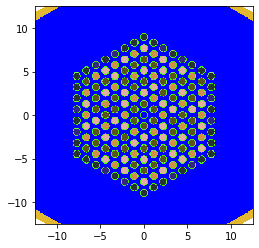

In [20]:
assembly_cell.fill = lat

u_root.add_cells([assembly_cell, reflect_cell, top_reflect_cell, bot_reflect_cell])
geom=openmc.Geometry(u_root)
geom.export_to_xml()

u_root.plot(origin=(0,0,0),width=(25,25),color_by='material',colors={water:'blue'},pixels=[400,400])

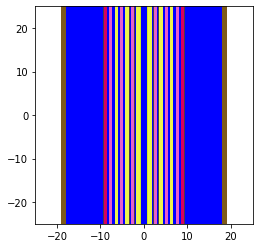

In [21]:
u_root.plot(basis='yz',origin=(0,0,0),width=(50,50),color_by='material',colors={water:'blue'},pixels=[200,200])

In [22]:
# OpenMC simulation parameters

batches = 100
inactive = 10
particles = 5000

settings = openmc.Settings()
settings.batches = batches
settings.inactive = inactive
settings.particles = particles

uniform_dist = openmc.stats.Box([-24,-24,-75],[24,24,75],only_fissionable=True)
settings.source = openmc.source.Source(space=uniform_dist)

settings.export_to_xml()

In [23]:
openmc.run()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

       91/1    0.36379    0.36378 +/- 0.00121
       92/1    0.37030    0.36386 +/- 0.00120
       93/1    0.36556    0.36388 +/- 0.00119
       94/1    0.39963    0.36430 +/- 0.00125
       95/1    0.37369    0.36441 +/- 0.00124
       96/1    0.37141    0.36449 +/- 0.00123
       97/1    0.36872    0.36454 +/- 0.00121
       98/1    0.37599    0.36467 +/- 0.00121
       99/1    0.38600    0.36491 +/- 0.00122
      100/1    0.36745    0.36494 +/- 0.00120
 Creating state point statepoint.100.h5...

 =======================>     TIMING STATISTICS     <=======================

 Total time for initialization     = 4.6179e+00 seconds
   Reading cross sections          = 4.5650e+00 seconds
 Total time in simulation          = 1.2380e+01 seconds
   Time in transport only          = 1.2340e+01 seconds
   Time in inactive batches        = 1.1459e+00 seconds
   Time in active batches          = 1.1234e+01 seconds
   Time synchronizing fission bank = 1.6836e-02 seconds
     Sampling source sites